Novembre 2019
<div align='center'><h2>SD701 Project - London bike sharing</h2></div>
<div align='center'>Camille COCHENER</div>

<img src="https://st2.depositphotos.com/1671840/7755/i/950/depositphotos_77554992-stock-photo-london-rental-bike.jpg" width="400"/>

<b>Contexte</b>
<p><div align='justify'>Les systèmes de vélos en libre-service ont été initiés par le projet vélo blanc du mouvement Provo à Amsterdam dans les années 60. Ce mouvement avait pour but de supprimer la circulation automobile et les embouteillages. Aujourd'hui, les bornes de vélos en libre-service sont largement répandues dans la plupart des grandes villes (Paris, New York, Londres...). Ce service de mobilité permet d'effectuer des déplacements de proximité en milieu urbain. C'est une forme de consommation collaborative qui permet de palier au vol des vélos personnels, leur maintenance et à leur stationnement à domicile.  
Dans une ville comme Paris ou Londres, on retrouve un certain nombre de bornes libre-service où l'on peut emprunter un vélo pour se déplacer. Mais il arrive très souvent que l'usager se retrouve face à une borne complètement vide, il ne peut alors pas emprunter de vélo, ou bien pleine, et il ne peut pas déposer son vélo là il l'avait souhaité. Ces deux points altèrent la satisfaction de l'usager et peuvent entrainer des pertes de clients pour l'entreprise. Il est donc particulièrement important de bien gérer le nombre de vélos disponibles à chaque borne.</div></p>

<b>Objectif</b>
<p><div align='justify'>Ce projet a pour objectif de construire un modèle prédictif du nombre de vélos partagés par heure à une borne à Londres.</div></p>

<b>Les données</b>
<p><div align='justify'>Le jeu de données contient 17414 lignes qui correspondent aux différents relevés à une heure et un jour donné. On supposera que ces données représentent un échantillon d'un jeu de données trop volumineux pour la mémoire et les temps de calcul, nécessitant ainsi l'utilisation de Spark.  
Pour chaque relevé, on dispose des informations suivantes :     
<ul>
<li> timestamp : date et heure de la journée </li>
<li> cnt : nombre de partage par heure </li>
<li> t1 : température mesurée (°C)</li>
<li> t2 : température ressentie (°C)</li>
<li> hum : humidité de l'air (%)</li>
<li> wind_speed : vitesse du vent (km/h)</li>
<li> weather_code : code météorologique</li>
<li> is_holiday : le jour est-il un jour de vacances</li>
<li> is_weekend : le jour est-il un jour de weekend</li>
<li> season : saison de l'année</li>
</ul>
</div></p>

<p><div align='justify'>Le jeu de données est issu de trois sources :  
<ul>
<li>https://cycling.data.tfl.gov.uk/ données historiques de partage de vélo à Londres 'Powered by TfL Open Data'</li>
    <li>freemeteo.com - données météorologiques</li>
    <li>https://www.gov.uk/bank-holidays du 01/01/2015 au 31/12/2016</li></ul>
</div></p>

<b>Etapes d'analyse</b>
<p>Cette étude se déroulera en deux temps : 
<ol>
    <b><li>Exploration des données</li></b>
        <ul>
            <li>Description des données (statistiques descriptives, valeurs manquantes)</li>
            <li>Création de variables à partir de <i>timestamp</i></li>
            <li>Influence des variables temporelles</li>
            <li>Influence des variables météorologiques</li>
            <li>Distribution de la variable à expliquer</li>
        </ul>  
    <b><li>Machine learning</li></b>
        <ul>
            <li>Préparation des données pour la modélisation</li>
            <li>Modélisation</li>
            <li>Prédiction et évaluation du modèle</li>
            <li>Analyse du modèle</li>
            <li>Pistes d'amélioration</li>
    </ul>
    </ol>
    </p>

<p><div align='justify'>Ce notebook tourne avec Python 3.6.5 et Spark 2.4.4.</div></p>

<b>Création de l'environnement Spark</b>
<div align='justify'>Une session Spark est créée pour pouvoir accéder à toutes les fonctionnalités de Spark sans avoir à créer différents contextes spécifiques.</div>

In [76]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

In [77]:
spark = SparkSession.builder.appName(
    'London bike sharing').getOrCreate()

<b>Librairies utilisées</b>

In [78]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import year, month, dayofmonth, hour, col
from pyspark.sql import functions as fct
from pyspark.sql.functions import mean, min, max

<b>Chargement des données</b>
<p><div align='justify'>Les données sont chargées dans un DataFrame afin de faciliter leur manipulation.</div></p>

In [79]:
# Importation des données
bike = spark.read.csv("london_bike_sharing.csv", header=True, inferSchema=True)

Aperçu des données :

In [80]:
bike.show(5)

+-------------------+---+---+---+-----+----------+------------+----------+----------+------+
|          timestamp|cnt| t1| t2|  hum|wind_speed|weather_code|is_holiday|is_weekend|season|
+-------------------+---+---+---+-----+----------+------------+----------+----------+------+
|2015-01-04 00:00:00|182|3.0|2.0| 93.0|       6.0|         3.0|       0.0|       1.0|   3.0|
|2015-01-04 01:00:00|138|3.0|2.5| 93.0|       5.0|         1.0|       0.0|       1.0|   3.0|
|2015-01-04 02:00:00|134|2.5|2.5| 96.5|       0.0|         1.0|       0.0|       1.0|   3.0|
|2015-01-04 03:00:00| 72|2.0|2.0|100.0|       0.0|         1.0|       0.0|       1.0|   3.0|
|2015-01-04 04:00:00| 47|2.0|0.0| 93.0|       6.5|         1.0|       0.0|       1.0|   3.0|
+-------------------+---+---+---+-----+----------+------------+----------+----------+------+
only showing top 5 rows



Le jeu de données est constitué de :
* 2 variables nominales <i>season</i> et <i>weather_code</i>, chacune à 4 modalités (de 1.0 à 4.0)
* 2 variables binaires <i>is_holiday</i> et <i>is_weekend</i> (prend la valeur 0.0 ou 1.0)
* 4 variables quantitatives continues <i>t1</i>, <i>t2</i>, <i>hum</i> et <i>wind_speed</i>
* 1 variable temporelle <i>timestamp</i>
* <i>cnt</i> la variable à expliquer

<h2><font color='darkred'>1. Exploration des données</font></h2>

<div align='justify'>La première partie du projet consiste à explorer les données afin de mieux comprendre leur contenu. On étudie les indicateurs de position et de dispersion, la présence ou non de valeurs manquantes, la présence de valeurs abberantes, la distribution des variables, les éventuelles corrélations entre les variables explicatives et entre chaque variable explicative et la variable à expliquer.</div>

<b><h3><font color='darkblue'>a) Description des données</font></h3></b>
<div align='justify'><b>Types des données</b></div>

In [81]:
bike.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- t1: double (nullable = true)
 |-- t2: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- weather_code: double (nullable = true)
 |-- is_holiday: double (nullable = true)
 |-- is_weekend: double (nullable = true)
 |-- season: double (nullable = true)



<div align='justify'>La plupart des données sont numériques. Il n'y aura donc pas besoin d'indexer de variables pour la modélisation.</div>

<b>Statistiques descriptives pour les variables continues</b>

In [82]:
# Affichage des statistiques descriptives
num_cols = ['cnt', 't1', 't2', 'hum', 'wind_speed']
bike.select(num_cols).describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+
|summary|               cnt|                t1|               t2|               hum|        wind_speed|
+-------+------------------+------------------+-----------------+------------------+------------------+
|  count|             17414|             17414|            17414|             17414|             17414|
|   mean|1143.1016423567244|12.468090808162016|11.52083572604418| 72.32495405995176|15.913063244133076|
| stddev|1085.1080679362196|  5.57181756292053|6.615144673127889|14.313186095310893|7.8945703293611755|
|    min|                 0|              -1.5|             -6.0|              20.5|               0.0|
|    max|              7860|              34.0|             34.0|             100.0|              56.5|
+-------+------------------+------------------+-----------------+------------------+------------------+



> <div align='justify'>Les variables quantitatives n'ont pas de valeurs manquantes car le nombre de lignes non vides est égal au nombre de lignes totales. Par ailleurs, il n'y a pas non plus de valeurs aberantes. Le nombre de location est toujours positif (<i>cnt</i>), les valeurs de températures s'échelonnent entre -6.0 et 34.0°C, ce qui est normal pour Londres. L'humidité est comprise entre 20.5 et 100.0%, et la vitesse du vent entre 0.0 et 56.5 km/h.</div>

<b>Statistiques descriptives pour les variables catégorielles</b>

In [83]:
bike.groupBy('weather_code').count().show()
bike.groupBy('is_holiday').count().show()
bike.groupBy('is_weekend').count().show()
bike.groupBy('season').count().show()

+------------+-----+
|weather_code|count|
+------------+-----+
|         7.0| 2141|
|         1.0| 6150|
|         4.0| 1464|
|         3.0| 3551|
|         2.0| 4034|
|        10.0|   14|
|        26.0|   60|
+------------+-----+

+----------+-----+
|is_holiday|count|
+----------+-----+
|       0.0|17030|
|       1.0|  384|
+----------+-----+

+----------+-----+
|is_weekend|count|
+----------+-----+
|       0.0|12444|
|       1.0| 4970|
+----------+-----+

+------+-----+
|season|count|
+------+-----+
|   0.0| 4394|
|   1.0| 4387|
|   3.0| 4330|
|   2.0| 4303|
+------+-----+



> <div align='justify'>Du côté des variables catégorielles, on peut voir que la variable <i>weather_code</i> n'est pas bien proportionnée pour deux catégories (10.0 et 26.0) qui sont largement sous-représentées. Il est judicieux de retirer ces catégories car elles n'apporteront pas d'informations.  
    Par ailleurs, la variable <i>is_holiday</i> est également mal proportionnée car plus de 95% correspond à des zéros. Quasiment la totalité des relevés est donc issu de jours hors vacances. Il est également pertinent de retirer cette variable.</div>

In [84]:
# On retire les modalités 10.0 et 26.0 de la variable weather_code
bike = bike.filter((bike.weather_code != 10.0) & (bike.weather_code != 26.0))

In [85]:
# On retire la variable is_holiday
bike = bike.drop('is_holiday')

<b><font color='darkblue'><h3>b) Création de variables à partir de timestamp</h3></font></b>
<p><div align='justify'>La variable temporelle <i>timestamp</i> ne peut pas être utilisée telle quelle. Il faut en extraire les différentes composantes, <i>i.e</i> le mois, le jour, l'heure de la journée. Ces informations sont importantes à prendre en compte car intuitivement, on s'attend à ce qu'il y ait des variations du nombre de vélos partagés au cours de la journée, mais également entre le jour et la nuit par exemple. La variable <i>timestamp</i> a permis la création de trois variables : <i>year</i>, <i>month</i> et <i>hour</i>.</div></p>

In [86]:
# Création des trois colonnes
bike = bike \
    .withColumn('year', year(col('timestamp'))) \
    .withColumn('month', month(col('timestamp'))) \
    .withColumn('hour', hour(col('timestamp')))

L'enjeu étant de prédire le nombre optimal de vélos à mettre à la borne, la variable <i>year</i> sera moins intéressante car elle ne représente pas un événement répétitif comme le mois ou le jour. Nous pouvons la supprimer.

In [87]:
# On retire la variable year
bike = bike.drop('year')

<div align='justify'>On retire également la variable <i>timestamp</i> à partir desquelles ont été créées les nouvelles variables car elle ne servira pas à modéliser la variable <i>cnt</i>.</div>

In [88]:
# On retire la variable timestamp
bike = bike.drop('timestamp')

Il est possible de représenter graphiquement l'évolution du nombre de vélos loués par heure en fonction du temps.

<b><font color='darkblue'><h3>c) Influence des variables temporelles</h3></font></b>

- <b>Effet des mois de l'année</b>

Text(0.5, 0, "Mois de l'année")

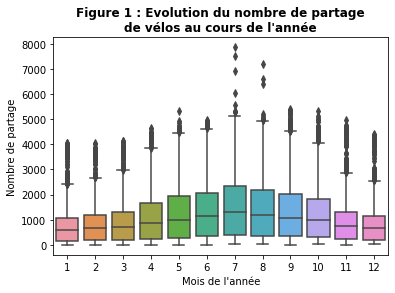

In [89]:
# Graphique de l'évolution du nombre de partage en fonction des mois de l'année
fig, ax = plt.subplots()
df_bike = bike.toPandas()
sns.boxplot(data=df_bike, x='month', y='cnt', ax=ax)
ax.set_title("Figure 1 : Evolution du nombre de partage\nde vélos au cours de l'année", fontweight='bold')
ax.set_ylabel('Nombre de partage')
ax.set_xlabel("Mois de l'année")

> <div align='justify'>Le nombre de partages augmente progressivement de janvier à juin/juillet puis diminue progressivement jusqu'à décembre. Cette tendance peut s'expliquer par l'effet du changement des saisons au cours de l'année.</div>

<div align='justify'>Ensuite, les fluctuations du nombre de vélos partagés ont été observées au cours de la journée, en fonction de : si le jour est travaillé ou non et si c'est un jour de vacances scolaires ou non.</div>

- <b>Effet de l'heure de la journée</b>

Text(0.5, 0, 'Heure de la journée')

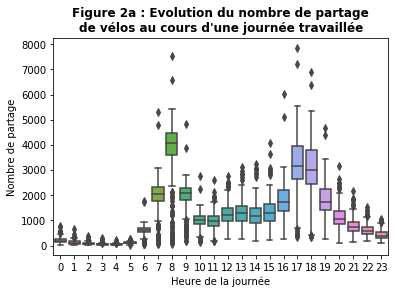

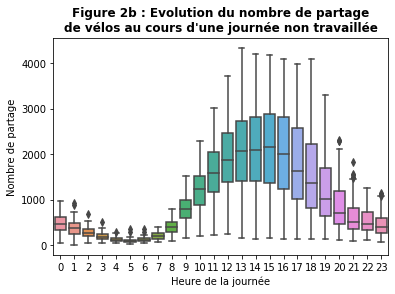

In [90]:
# Graphique de l'évolution du nombre de partage au cours d'une journée travaillée
fig, ax = plt.subplots()
df_bike = bike.toPandas()
sns.boxplot(data=df_bike[df_bike["is_weekend"]==0], x='hour', y='cnt', ax=ax)
ax.set_title("Figure 2a : Evolution du nombre de partage\nde vélos au cours d'une journée travaillée", fontweight='bold')
ax.set_ylabel('Nombre de partage')
ax.set_xlabel("Heure de la journée")

# Graphique de l'évolution du nombre de partage au cours d'une journée non travaillée
fig, ax = plt.subplots()
df_bike = bike.toPandas()
sns.boxplot(data=df_bike[df_bike["is_weekend"]==1], x='hour', y='cnt', ax=ax)
ax.set_title("Figure 2b : Evolution du nombre de partage\nde vélos au cours d'une journée non travaillée", fontweight='bold')
ax.set_ylabel('Nombre de partage')
ax.set_xlabel("Heure de la journée")

> <div align='justify'>Sur le premier graphique (Figure 2a), on peut remarquer qu'au cours d'une journée travaillée, on distingue des pics entre 6h-10h et 16h-20h, qui correspondent aux heures de pointes d'une journée de travail. Entre 10h et 16h, ce sont les heures creuses. En revanche, on peut voir sur la Figure 2b, qu'au cours d'une journée de week-end, le nombre de vélos partagés est globalement important (de 1000 à 2000 en moyenne) entre 9h et 19h (quasiment toute la journée). La nuit, ce nombre est faible (inférieur à 500 en moyenne).  
Il y a également une différence nette entre le nombre de vélos partagés la nuit (entre 21h et 6h du matin) et la journée (entre 7h et 20h).</div>

<b><font color='darkblue'><h3>d) Influence des variables météorologiques</h3></font></b>

- <b>Effet de la température</b>

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 10 Text xticklabel objects>)

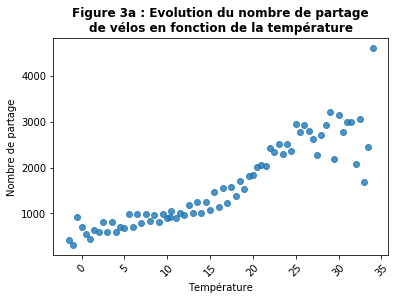

In [91]:
# Graphique de l'évolution du nombre de partage en fonction de la température
fig, ax = plt.subplots()
temp = bike.groupby('t1').mean('cnt')
df_temp = temp.toPandas().round(3)
sns.regplot(data=df_temp, x='t1', y='avg(cnt)', ax=ax, fit_reg=False)
ax.set_title("Figure 3a : Evolution du nombre de partage\nde vélos en fonction de la température", fontweight='bold')
ax.set_ylabel('Nombre de partage')
ax.set_xlabel("Température")
plt.xticks(rotation=45)

(array([-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.]),
 <a list of 11 Text xticklabel objects>)

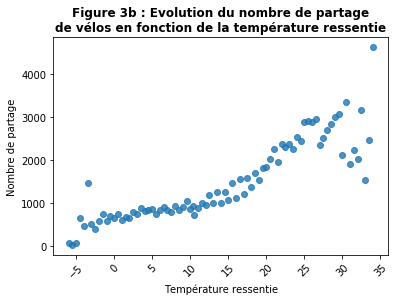

In [92]:
# Graphique de l'évolution du nombre de partage en fonction de la température ressentie
fig, ax = plt.subplots()
temp2 = bike.groupby('t2').mean('cnt')
df_temp2 = temp2.toPandas().round(3)
sns.regplot(data=df_temp2, x='t2', y='avg(cnt)', ax=ax, fit_reg=False)
ax.set_title("Figure 3b : Evolution du nombre de partage\nde vélos en fonction de la température ressentie", fontweight='bold')
ax.set_ylabel('Nombre de partage')
ax.set_xlabel("Température ressentie")
plt.xticks(rotation=45)

> <div align='justify'>Pour les deux types de température, il y a une forte corrélation avec le nombre de partages de vélos. C'est une variable qui semble très influente.  
Comme les deux tendances d'évolution sur les deux graphiques sont très similaires, étudions la corrélation entre les deux types de température.</div>

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 10 Text xticklabel objects>)

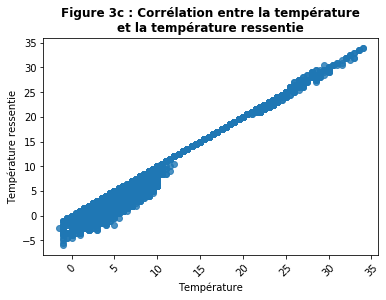

In [93]:
# Corrélation entre la température et la température ressentie
fig, ax = plt.subplots()
df_bike = bike.toPandas()
sns.regplot(data=df_bike, x='t1', y='t2', ax=ax, fit_reg=False)
ax.set_title("Figure 3c : Corrélation entre la température\net la température ressentie", fontweight='bold')
ax.set_ylabel('Température ressentie')
ax.set_xlabel("Température")
plt.xticks(rotation=45)

> <div align='justify'>Les deux variables "température" et "température ressentie" sont très corrélées. La relation entre les deux est linéaire. Inclure les deux variables dans le modèle reviendrait à ajouter une information redondante. Il suffit d'en choisir une des deux. Nous pouvons supprimer la variable <i>t1</i> (température).</div>

In [94]:
# On retire la variable t1
bike = bike.drop('t1')

- <b>Effet de la vitesse du vent</b>

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 <a list of 8 Text xticklabel objects>)

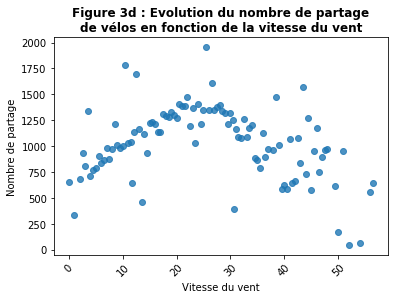

In [95]:
# Graphique de l'évolution du nombre de partage en fonction de la vitesse du vent
fig, ax = plt.subplots()
wind = bike.groupby('wind_speed').mean('cnt')
df_wind = wind.toPandas().round(3)
sns.regplot(data=df_wind, x='wind_speed', y='avg(cnt)', ax=ax, fit_reg=False)
ax.set_title("Figure 3d : Evolution du nombre de partage\nde vélos en fonction de la vitesse du vent", fontweight='bold')
ax.set_ylabel('Nombre de partage')
ax.set_xlabel("Vitesse du vent")
plt.xticks(rotation=45)

><div align='justify'>Il n'y a pas de lien clairement linéaire entre le nombre de partages et la vitesse du vent. On note une tendance linéaire lorsque la vitesse du vent est comprise entre 0 et 30 km/h : plus la vitesse du vent augmente et plus le nombre de partage de vélos augmente. A l'inverse, dès que la vitesse du vent dépasse 30 km/h, le nombre de partage de vélos semble diminuer lorsque la vitesse du vent augmente. Cette variable est tout de même conservée dans l'analyse.</div> 

- <b>Effet de l'humidité</b>

(array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.]),
 <a list of 11 Text xticklabel objects>)

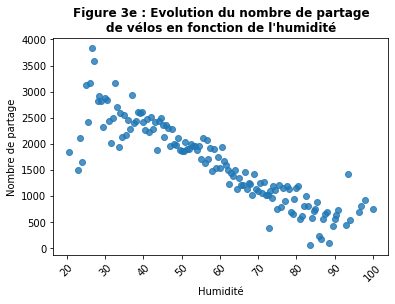

In [96]:
# Graphique de l'évolution du nombre de partage en fonction de l'humidité
fig, ax = plt.subplots()
hum = bike.groupby('hum').mean('cnt')
df_hum = hum.toPandas().round(3)
sns.regplot(data=df_hum, x='hum', y='avg(cnt)', ax=ax, fit_reg=False)
ax.set_title("Figure 3e : Evolution du nombre de partage\nde vélos en fonction de l'humidité", fontweight='bold')
ax.set_ylabel('Nombre de partage')
ax.set_xlabel("Humidité")
plt.xticks(rotation=45)

> <div align='justify'>Il existe un lien fort entre le nombre de vélos partagés et l'humidité. Plus l'humidité est importante (jours de pluie par exemple), plus le nombre de vélos partagés est faible.</div>

<b><h3><font color='darkblue'>e) Etude de la variable à expliquer</font></h3></b>
<div align='justify'>En pratique, il est important que la variable à expliquer suive une loi normale, car de nombreux algorithmes sont basés sur cette hypothèse. Pour étudier la distribution de la variable <i>cnt</i>, on représente son histogramme de distribution.</div>

Text(0, 0.5, 'Nombre de partage')

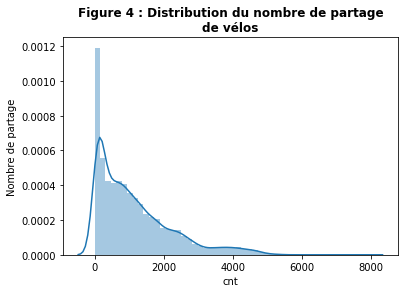

In [97]:
# Graphique de la distribution de la variable à expliquer cnt
fig, ax = plt.subplots()
df_bike = bike.toPandas()
sns.distplot(df_bike["cnt"], ax=ax)
ax.set_title("Figure 4 : Distribution du nombre de partage\nde vélos", fontweight='bold')
ax.set_ylabel('Nombre de partage')

> <div align='justify'>Visiblement, d'après la Figure 4, la variable <i>cnt</i> n'a pas une distribution normale. On peut lui appliquer une transformation logarithmique pour approcher une distribution normale.</div>

In [98]:
# Transformation logarithmique de la variable à expliquer
bike = bike.withColumn('cnt', fct.log(bike.cnt))

Après le passage au logarithme, on peut s'attendre à ce qu'il y ait présence de valeurs nulles dans la variable à expliquer lorsque le nombre de vélos partagés était de zéro (car le log est défini sur $\mathbf{R}_{*}$). Nous allons donc remplacer les valeurs nulles par zéro.

In [99]:
bike_modeling = bike.fillna({'cnt':'0'})

**Conclusion**  

**Le nombre de vélos partagés par heure semble dépendre de plusieurs facteurs temporelles et météorologiques : le mois/la saison, l'heure de la journée, le type de journée, la température ressentie, l'humidité et la vitesse du vent.**  

Existe-t-il un modèle permettant de prédire le nombre de vélos loués par heure en fonction de ces paramètres ?

<h2><font color='darkred'>2. Machine Learning</font></h2>

In [100]:
# Librairies utilisées
from pyspark.ml.feature import VectorAssembler, OneHotEncoderEstimator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

<div align='justify'>On chercher maintenant à définir un modèle permettant de prédire le nombre de vélos partagés par heure grâce aux différents facteurs énoncés précédemment.</div>

In [101]:
bike_modeling.show(5)

+------------------+---+-----+----------+------------+----------+------+-----+----+
|               cnt| t2|  hum|wind_speed|weather_code|is_weekend|season|month|hour|
+------------------+---+-----+----------+------------+----------+------+-----+----+
| 5.204006687076795|2.0| 93.0|       6.0|         3.0|       1.0|   3.0|    1|   0|
| 4.927253685157205|2.5| 93.0|       5.0|         1.0|       1.0|   3.0|    1|   1|
| 4.897839799950911|2.5| 96.5|       0.0|         1.0|       1.0|   3.0|    1|   2|
| 4.276666119016055|2.0|100.0|       0.0|         1.0|       1.0|   3.0|    1|   3|
|3.8501476017100584|0.0| 93.0|       6.5|         1.0|       1.0|   3.0|    1|   4|
+------------------+---+-----+----------+------------+----------+------+-----+----+
only showing top 5 rows



<b><h3><font color='darkblue'>a) Préparation des données pour le ML</font></h3></b>
<div align='justify'>Lorsqu'on souhaite entrainer un algorithme avec Spark, nous avons besoin de transformer le tableau de données de manière :</div>  

* <div align='justify'>Toutes les colonnes doivent être numériques, ce qui est notre cas, nous n'avons pas besoin d'indexer des catégories avec StringIndexer par exemple.</div> 
  
* <div align='justify'>En revanche, certaines colonnes catégorielles sont indexées par des chiffres de 1 à 4 et il est nécessaire d'indiquer à l'algorithme que les modalités ont des poids identiques. Par exemple, les saisons de la variable <i>season</i> sont représentées par des chiffres de 1 à 4, mais la saison 4 n'est pas meilleure que la saison 1. Pour cela, les variables catégorielles sont recodées en variables binaires (OneHotEncodingEstimator). La première modalité n'est pas conservée (argument dropLast=True) pour éviter la multicollinéarité avec les variables des autres modalités.</div> 

In [103]:
# One Hot Encoding sur les variables season, weather_code, hour et month
encoder = OneHotEncoderEstimator(inputCols=["season", "weather_code", "hour", "month"],
                                 outputCols=["seasonVec", "weather_codeVec", "hourVec", "monthVec"],
                                dropLast=True)

* Enfin, nous avons besoin de deux colonnes : une contenant les paramètres ("features") et une contenant la variable à prédire ("cnt").

In [113]:
features = ['hum',
            't2',
            'wind_speed',
            'monthVec',
            'hourVec',
            'seasonVec',
            'weather_codeVec',
            'is_weekend']

In [114]:
# Création de l'assembler
assembler = VectorAssembler()\
    .setInputCols(features)\
    .setOutputCol("features")

<b><h3><font color='darkblue'>b) Modélisation</font></h3></b>
<div align='justify'>Une fois les données prêtes, nous pouvons passer à la partie modélisation. Dans un premier temps, on découpe les données en un jeu d'entrainement et un jeu de test. Ensuite, on construit une grille de recherche afin de rassembler les hyperparamètres du modèle à tester. Les hyperparamètres seront déterminés par validation croisée. Enfin, on testera le pouvoir prédictif du modèle sur le jeu de test.  

<p>Le modèle choisi pour ce projet est l'algorithme des "forêts aléatoires" (Random Forests).</p></div>

- <b>Découpage des données en un jeu d'entrainement et un jeu de test</b>

Afin de pouvoir tester le modèle sur des données non vues par l'algorithme pendant l'apprentissage, le jeu de données est découpé en deux parties :
* Un jeu d'apprentissage (80% des données)
* Un jeu de test (20% des données) 

In [115]:
(trainingData, testData) = bike_modeling.randomSplit([0.8, 0.2])

- <b>Création du modèle Random Forest</b>

<div align='justify'>L'algorithme de "forêts aléatoires" a pour avantage de réduire les risques de surajustement et de fournir des résultats performants et précis.</div>

In [116]:
rf = RandomForestRegressor(featuresCol="features", labelCol="cnt")

- <b>Création d'une grid search pour trouver les meilleurs hyperparamètres</b> 

L'algorithme des "forêts aléatoires" nécessitant des hyperparamètres comme :
* La profondeur maximale des arbres 
* Le nombre d'individus minimale à chaque feuille
* Le nombre d'arbres de décision à construire  

<div align='justify'>Une grille de recherche est construite pour tester plusieurs combinaisons d'hyperparamètres afin de sélectionner celle qui donne la meilleure performance.</div>

In [117]:
rfparamGrid = ParamGridBuilder() \
               .addGrid(rf.maxDepth, [4, 6, 8, 10]) \
               .addGrid(rf.maxBins, [50, 100, 150]) \
               .addGrid(rf.numTrees, [50, 100, 150]) \
               .build()

- <b>Création du pipeline</b>

<div align='justify'>On crée ensuite le pipeline qui regroupe la préparation des données et le modèle à entrainer.</div>

In [118]:
stages = [encoder, assembler, rf]
pipe = Pipeline(stages=stages)

- <b>Création de l'évaluateur</b>

<div align='justify'>La variable à prédire étant quantitative, le critère de performance utilisé pour le choix du modèle est le RMSEP (Root Mean Square Error Prediction). Il s'agit de la différence entre les valeurs prédites et les valeurs observées, encore appelée erreur quadratique moyenne. Plus le RMSEP est faible, meilleure est la prédiction. </div>

In [119]:
evaluator = RegressionEvaluator(labelCol="cnt", predictionCol="prediction", metricName="rmse")

- <b>Création de la validation croisée</b>

<div align='justify'>Le modèle est entrainé par validation croisée afin d'éviter le surajustement : le jeu d'apprentissage est découpé en plusieurs "folds" (ici 5) et pour chaque fold k, le modèle est entrainé sur la partie qui ne contient pas le fold (k-1) puis testé sur le fold k. L'erreur de validation est calculée pour chaque fold puis moyennée sur tout les folds à la fin. On effectue une validation croisée pour chaque combinaison d'hyperparamètres.</div>

In [120]:
rfcv = CrossValidator(estimator = pipe,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)

- <b>Entrainement du modèle</b>

In [121]:
cvmodel = rfcv.fit(trainingData)

In [122]:
bike_rf = cvmodel.transform(trainingData)

<b><h3><font color='darkblue'>c) Prédictions et évaluation du modèle</font></h3></b>
<div align='justify'>Afin d'évaluer le modèle, on prédit les valeurs du jeu de test, puis on les compare avec les vraies valeurs.</div>

- <b>Prédictions sur le jeu de test</b>

In [123]:
predictions = cvmodel.transform(testData)

In [131]:
predictions.select("prediction", "cnt", "features").show(10)

+------------------+------------------+--------------------+
|        prediction|               cnt|            features|
+------------------+------------------+--------------------+
|3.8740922509102105|  2.70805020110221|(49,[0,1,2,8,18,3...|
|  4.57947494027029| 2.772588722239781|(49,[0,1,2,14,17,...|
|3.9434865102550067| 2.833213344056216|(49,[0,1,2,4,17,4...|
| 4.172697198143684|2.9444389791664403|(49,[0,1,2,5,17],...|
| 3.778162018505489| 2.995732273553991|(49,[0,1,2,5,18,4...|
|3.6920415868027816| 3.091042453358316|(49,[0,1,2,5,18,4...|
|3.4649036677989753|3.1354942159291497|(49,[0,1,2,4,18,4...|
|3.7462614212255434|3.1780538303479458|(49,[0,1,2,14,18,...|
|3.6015029792937336|3.2188758248682006|(49,[0,1,2,5,19,4...|
| 3.603087703555854| 3.258096538021482|(49,[0,2,14,18,40...|
+------------------+------------------+--------------------+
only showing top 10 rows



- <b>Evaluation du modèle</b>

In [125]:
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.530224


<div align='justify'>L'avantage du RMSE est qu'il s'exprime dans la même unité que la variable réponse. Ici, il s'interprète comme un pseudo écart-type de la variance inexpliquée du modèle. Chaque valeur est prédite avec plus ou moins 0.53 points d'incertitude. Rapporté aux valeurs des données, cela représente une bonne prédiction.</div>  

<b><h3><font color='darkblue'>d) Analyse du modèle</font></h3></b>
<div align='justify'>Dans le cas d'un modèle de forêts aléatoires, il est utile d'afficher l'importance des variables afin de voir quelles sont les variables qui influencent beaucoup la prédiction. </div>

In [126]:
# Fonction qui retourne un dataframe contenant l'importance des variables
# Source : https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [127]:
ExtractFeatureImp(cvmodel.bestModel.stages[-1].featureImportances, bike_rf, "features").head(10)

,idx,name,score
0,0,hum,0.196269
20,19,hourVec_4,0.164616
19,18,hourVec_3,0.145095
18,17,hourVec_2,0.104376
21,20,hourVec_5,0.096047
17,16,hourVec_1,0.067793
3,48,is_weekend,0.053642
1,1,t2,0.053186
16,15,hourVec_0,0.032988
24,23,hourVec_8,0.019686


Le format n'est pas idéal car chaque modalité de chaque variable s'affiche. 
Cependant, nous pouvons apporter quelques éléments de conclusions : 
* L'humidité est un des premiers facteurs influençant le nombre de vélos partagés à une borne
* L'heure de la journée ainsi que le fait que le jour soit un week-end ou pas semble également influée
* La température ressentie est le troisième facteur qui apparaît comme influent

<b><h3><font color='darkblue'>e) Pistes d'amélioration</font></h3></b>

Ce modèle pourrait être amélioré :
* Par l'ajout d'autres variables qui pourraient également avoir une influence sur le nombre de vélos loués par heure (par exemple le quartier de la ville, le nombre d'habitants aux alentours de la borne)
* Par le test d'autres modèles 